## Importing (standard) modules

In [1]:
%reset -f

In [2]:
# Data/vector handeling and extra math
import numpy as np
import pandas as pd
import math

# Optimisation
import scipy
from scipy import optimize
import sklearn.metrics as metrics

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Error handeling
import warnings

# Time
import time
import datetime

# System/file interaction
import os
import pickle# https://www.pythoncentral.io/how-to-pickle-unpickle-tutorial/
import shelve# https://stackoverflow.com/questions/2960864/how-to-save-all-the-variables-in-the-current-python-session

## Importing from file

In [3]:
#from helpers import *
#from exampleHelpers import *

# Data importing

In [5]:
# Intensity (a.u.) from Rayleigh signal
# Dim 1: radial position, -1 to +1 mm
# Dim 2: spectral distribution, 531 to 533 nm

#data_off = pd.read_csv("scattering_rayleigh_plasma_off.csv",delimiter=" ", header=None)
#data_on = pd.read_csv("scattering_rayleigh_plasma_on.csv",delimiter=" ", header=None)

data_off = np.genfromtxt("scattering_rayleigh_plasma_off.csv", delimiter =  " ")
data_on = np.genfromtxt("scattering_rayleigh_plasma_on.csv", delimiter =  " ")
#print(np.shape(data_off), "\n")
#print(data_off, "\n")
#print(data_off[0], "\n")
#data_off[position][wavelength]

space = np.linspace(-1, 1, num=len(data_on))
wavelength = np.linspace(531, 533, num=len(data_on.transpose()))

def get_max_wavelength(spectrum):
    max_wavelength = wavelength[np.abs(spectrum - max(spectrum)).argmin()]
    return max_wavelength

# Question 2A

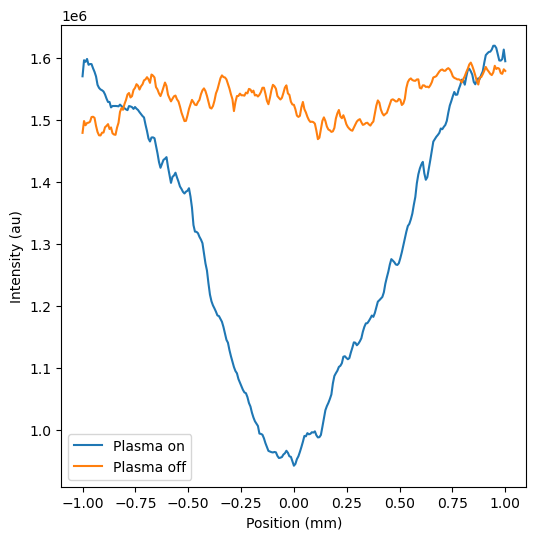

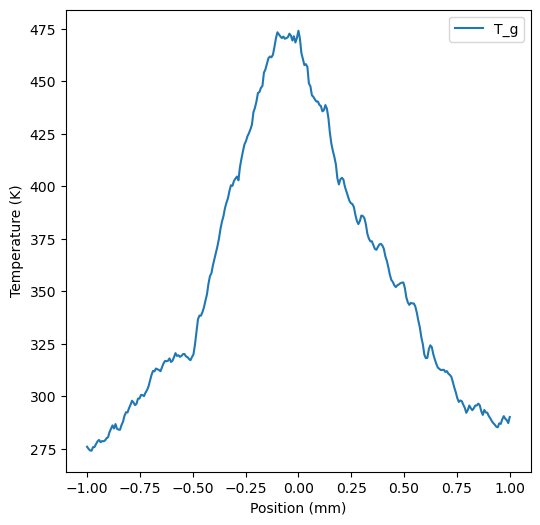

In [6]:
spatial_power_on = np.array([np.sum(i) for i in data_on])# Sum each row for spetial
spatial_power_off = np.array([np.sum(i) for i in data_off])# Sum each row for spetial
#https://en.wikipedia.org/wiki/Raman_scattering#Raman_scattering

gass_temperature = 293*spatial_power_off/spatial_power_on

fig, ax = plt.subplots(1, 1, figsize = (6,6))
ax.plot(space, spatial_power_on, label="Plasma on")
ax.plot(space, spatial_power_off, label="Plasma off")
ax.set_xlabel("Position (mm)")
ax.set_ylabel("Intensity (au)")
#ax.set_title("Spectral power")
ax.legend()
fig.savefig('Figures/TotalPowerPerPosition.pdf', dpi=1200)

fig, ax2 = plt.subplots(1, 1, figsize = (6,6))
ax2.plot(space, gass_temperature, label="T_g")
ax2.set_xlabel("Position (mm)")
ax2.set_ylabel("Temperature (K)")
#ax2.set_title("Gas temperature")
ax2.legend()
fig.savefig('Figures/GasTemperature.pdf', dpi=1200)

# Question 2B

In [7]:
from scipy.special import wofz

def Gauss(x, x0, y0, a, sigma):#https://stackoverflow.com/questions/59049433/fitting-voigt-function-to-data-in-python
    return y0 + a * np.exp(-(x - x0)**2 / (2 * sigma**2))

def Voigt(x, x0, y0, a, sigma, gamma):#https://stackoverflow.com/questions/59049433/fitting-voigt-function-to-data-in-python
    #sigma = alpha / np.sqrt(2 * np.log(2))

    return y0 + a * np.real(wofz((x - x0 + 1j*gamma)/sigma/np.sqrt(2))) / sigma /np.sqrt(2*np.pi)

## Spectrum on

Fit parameters: [5.32033333e+02 2.81024284e+02 8.54936289e+04 5.21046491e-02] with standard deviation [3.62963858e-04 9.72434917e+01 5.20321551e+02 3.72515459e-04]
FWHM_Gauss: 0.12270644854788651+-0.0008772739051423465


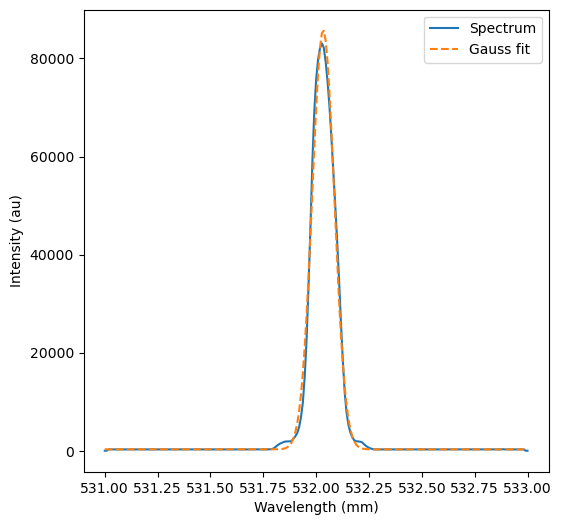

In [8]:
total_spectrum_on = np.array([np.sum(i) for i in data_on.transpose()])/len(data_on)
max_wavelengths_on = np.array([get_max_wavelength(i) for i in data_on])
middle_index = np.abs(total_spectrum_on - max(total_spectrum_on)).argmin()
index_range = 30

"""
sigmaGuess=0.1
gammaGuess=0.1
startingParameters = [np.mean(max_wavelengths_on), np.max(total_spectrum_on), -(np.max(total_spectrum_on)-np.min(total_spectrum_on)), sigmaGuess, gammaGuess]# Optional starting values of the parameters
popt, pcov = optimize.curve_fit(Voigt, wavelength, total_spectrum_on, startingParameters)# Make the fit.
fit = Voigt(wavelength, *popt)
print("Fit parameters:", popt, "with standard deviation", np.sqrt(np.diag(pcov)))
print("FWHM_Gauss: " + str(2.355*popt[-2])+"+-"+str(2.355*np.sqrt(np.diag(pcov))[-2]))
print("FWHM_Lor: " + str(2*popt[-1])+"+-"+str(2*np.sqrt(np.diag(pcov))[-1]))#"""

sigmaGuess=0.1
startingParameters = [np.mean(max_wavelengths_on), np.max(total_spectrum_on), -(np.max(total_spectrum_on)-np.min(total_spectrum_on)), sigmaGuess]# Optional starting values of the parameters
#popt, pcov = optimize.curve_fit(Gauss, wavelength[middle_index-index_range:middle_index+index_range], total_spectrum_on[middle_index-index_range:middle_index+index_range], startingParameters)# Make the fit.
popt, pcov = optimize.curve_fit(Gauss, wavelength, total_spectrum_on, startingParameters)# Make the fit.
fit = Gauss(wavelength, *popt)
print("Fit parameters:", popt, "with standard deviation", np.sqrt(np.diag(pcov)))
print("FWHM_Gauss: " + str(2.355*popt[-1])+"+-"+str(2.355*np.sqrt(np.diag(pcov))[-1]))

fig, ax = plt.subplots(1, 1, figsize = (6,6))
ax.plot(wavelength, total_spectrum_on, label="Spectrum")
#ax.plot(wavelength[middle_index-index_range:middle_index+index_range], fit[middle_index-index_range:middle_index+index_range], label="Gauss fit")
ax.plot(wavelength, fit, linestyle="--", label="Gauss fit")
#ax.axvline(get_max_wavelength(total_spectrum_on), color="k", linestyle="--")# Check dit
#ax.plot(wavelength, data_on[int(len(data_on)/2)], label="Spectrum in middle (scalled)")
ax.set_xlabel("Wavelength (mm)")
ax.set_ylabel("Intensity (au)")
#ax.set_title("Spectrum plasma on")
ax.legend()
fig.savefig('Figures/SpectrumPlasmaOn.pdf', dpi=1200)

Fit parameters: [5.32029966e+02 3.20566146e+02 1.03935054e+05 5.05758088e-02] with standard deviation [3.27893072e-04 1.08145454e+02 5.88538804e+02 3.36233076e-04]
FWHM_Gauss: 0.11910602980576107+-0.0007918288940499356


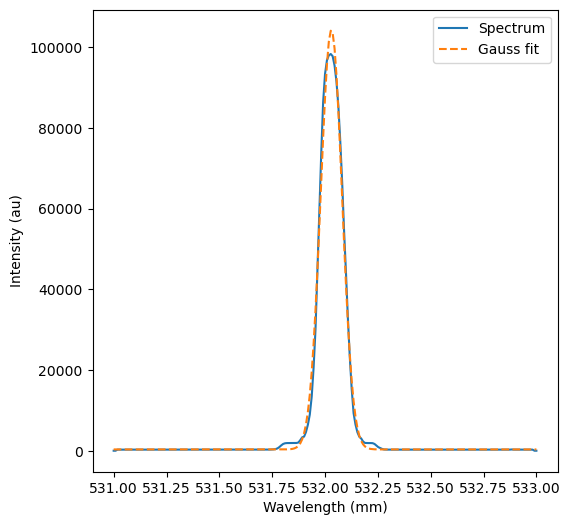

In [9]:
total_spectrum_off = np.array([np.sum(i) for i in data_off.transpose()])/len(data_off)
max_wavelengths_off = np.array([get_max_wavelength(i) for i in data_off])
middle_index = np.abs(total_spectrum_off - max(total_spectrum_off)).argmin()
middle_index = np.abs(total_spectrum_on - max(total_spectrum_on)).argmin()
index_range = 30

"""
sigmaGuess=0.1
gammaGuess=0.1
startingParameters = [np.mean(max_wavelengths_off), np.max(total_spectrum_off), -(np.max(total_spectrum_off)-np.min(total_spectrum_off)), sigmaGuess, gammaGuess]# Optional starting values of the parameters
popt, pcov = optimize.curve_fit(Voigt, wavelength, total_spectrum_off, startingParameters)# Make the fit., bounds=((-np.inf, -np.inf, -np.inf, -np.inf, 0), (np.inf, np.inf, np.inf, np.inf, np.inf))
fit = Voigt(wavelength, *popt)
print("Fit parameters:", popt, "with standard deviation", np.sqrt(np.diag(pcov)))
print("FWHM_Gauss: " + str(2.355*popt[-2])+"+-"+str(2.355*np.sqrt(np.diag(pcov))[-2]))
print("FWHM_Lor: " + str(2*popt[-1])+"+-"+str(2*np.sqrt(np.diag(pcov))[-1]))#"""

sigmaGuess=0.1
startingParameters = [np.mean(max_wavelengths_off), np.max(total_spectrum_off), -(np.max(total_spectrum_off)-np.min(total_spectrum_off)), sigmaGuess]# Optional starting values of the parameters
#popt, pcov = optimize.curve_fit(Gauss, wavelength[middle_index-index_range:middle_index+index_range], total_spectrum_on[middle_index-index_range:middle_index+index_range], startingParameters)# Make the fit.
popt, pcov = optimize.curve_fit(Gauss, wavelength, total_spectrum_off, startingParameters)# Make the fit.
fit = Gauss(wavelength, *popt)
print("Fit parameters:", popt, "with standard deviation", np.sqrt(np.diag(pcov)))
print("FWHM_Gauss: " + str(2.355*popt[-1])+"+-"+str(2.355*np.sqrt(np.diag(pcov))[-1]))

fig, ax = plt.subplots(1, 1, figsize = (6,6))# Make a plot.
ax.plot(wavelength, total_spectrum_off, label="Spectrum")
#ax.plot(wavelength[middle_index-index_range:middle_index+index_range], fit[middle_index-index_range:middle_index+index_range], label="Gauss fit")
ax.plot(wavelength, fit, linestyle="--", label="Gauss fit")
#ax.axvline(get_max_wavelength(total_spectrum_off), color="k", linestyle="--")# Check dit
#ax.plot(wavelength, data_off[int(len(data_off)/2)], label="Spectrum in middle (scalled)")
ax.set_xlabel("Wavelength (mm)")
ax.set_ylabel("Intensity (au)")
#ax.set_title("Spectrum plasma off")
ax.legend()
fig.savefig('Figures/SpectrumPlasmaOff.pdf', dpi=1200)